Carson Fox - A02251670

# Computing an Approximation of $\pi$

The Leibniz formula for $\pi$ can be derived from the power series of $\arctan(\theta)$. This results in the infinite series $\frac{\pi}{4} = 1 - \frac{1}{3} + \frac{1}{5} - \frac{1}{7} + \dots$ Summing a subset of this series will approximate pi, albeit quite slowly.

A classic integral approximation of $\pi$, attributed to Dalzell (1944), is given by: $\int_0^1 \frac{x^4(1-x)^4}{1+x^2} = \frac{22}{7} - \pi$. This formula is popular because it relates $\pi$ with its popular rational estimate $\frac{22}{7} \approx 3.142$. We can implement this using any numerical integration technique.

# Implementing approximations of $\pi$

The Leibniz formula can be implemented by summing a sequence of terms from the series.

In [1]:
function leibniz_pi(n)
    term(i) = (-1)^i * 1 / (2*i + 1)
    4 * sum(map(term, 0:n))
end

leibniz_pi (generic function with 1 method)

This approximation results in a dampened oscillation that converges very slowly to $\pi$.

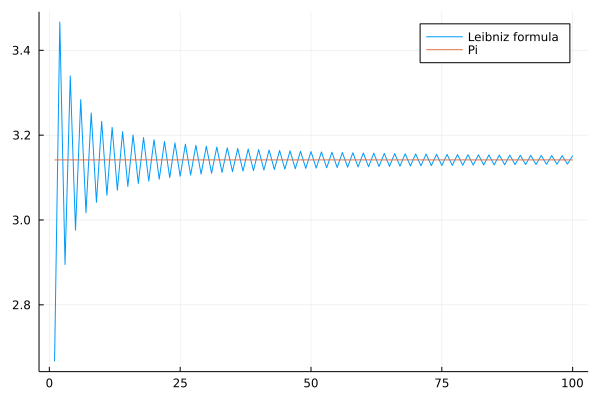

In [2]:
using Plots

exact(x) = pi
plot(1:100, [leibniz_pi, exact], labels=["Leibniz formula" "Pi"])

Recall our implementation of Simpson's rule:

In [3]:
function simpson(f, a, b, h)
    domain = a:h:b
    
    if !(b in domain)
        domain = vcat(domain, b)
    end
    
    @assert domain[end] == b
    
    pairs = zip(domain[1:end-1], domain[2:end])
    sum((bn - an) / 6 * (f(an) + 4f((an + bn) / 2) + f(bn)) for (an, bn) in pairs)
end

simpson (generic function with 1 method)

We can use this numerical integration rule to implement Dalzell's formula for $\pi$.

In [4]:
dalzell(h) = 22/7 - simpson(x -> x^4*(1-x)^4 / (1 + x^2), 0, 1, h)
dalzell(1e-6)

3.141592653589793

# Parallelization

The Julia language provides features similar to OpenMP by default, using the Threads module. Here we work on a machine with 8 threads:

In [5]:
Threads.nthreads()

8

Let's implement a parallel version of the Leibniz formula from earlier.

In [6]:
function leibniz_pi_parallel(n)
    term(i) = (-1)^i * 1 / (2*i + 1)
    
    # Promote sum to a vector
    sums = zeros(Threads.nthreads())
    
    # Equivalent to #pragma omp for
    Threads.@threads for i in 0:n
        sums[Threads.threadid()] += term(i)
    end
    
    4 * sum(sums)
end

leibniz_pi_parallel (generic function with 1 method)

If we plot this solution, we can verify that it behaves the same as the serial verion:

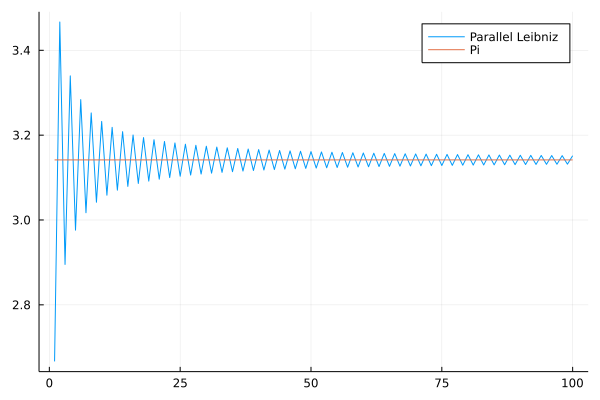

In [7]:
plot(1:100, [leibniz_pi_parallel, exact], labels=["Parallel Leibniz" "Pi"])

In order to more easily benchmark our implementations, we run them many times in a loop. This will make the speedup more obvious.

In [8]:
function benchmark(approx, n, iterations)
    @time for _ in 1:iterations
        approx(n)
    end
end

benchmark (generic function with 1 method)

Here we sum 10,000 terms of the Leibniz formula, 4,000 times each.

In [9]:
n = 10000
iter = 40000

40000

In [10]:
benchmark(leibniz_pi, n, iter)

 17.407046 seconds (80.00 k allocations: 2.984 GiB, 0.50% gc time)


In [11]:
benchmark(leibniz_pi_parallel, n, iter)

  5.184872 seconds (1.80 M allocations: 159.300 MiB, 0.98% gc time)


Although there is a noticable speedup, we don't see the speedup expected from this embarassingly parallel problem. This is because all of the elements of our sum vector will be in the same cache line.

# Approximation of $e$

One definition for $e^x$ is the solution to the first-order differential equation $y' = y$. Thus if we can approximate the solution to this equation and evaluate at $x = 1$, we will find an approximation for Euler's number.

Let's use the implicit Euler method for this task. For our root finding, we will use the Newton-Raphson method. This time we will use a second-order derivative approximation.

In [12]:
function derivative(f, h)
    x -> (f(x + h) - f(x - h)) / 2h
end

function newton_raphson(f, x0, max=1000, tol=1e-6)
    guess = x0
    df = derivative(f, tol)
    
    for i in 1:max
        error = abs(f(guess))
        if error < tol
            return guess
        end
        
        guess = guess - f(guess) / df(guess)
    end
    
    return guess
end

newton_raphson (generic function with 3 methods)

With this defined, recall the implicit Euler method:

In [13]:
function implicit_euler(f, y0, a, b, h)
    #Begin at t1
    t1 = a + h
    domain = t1:h:b
    yk = y0
    
    Y = [y0]
    
    for t in domain
        g(y) = yk + h*f(y) - y
        yk = newton_raphson(g, yk)
        Y = [Y; yk]
    end
    
    Y
end

implicit_euler (generic function with 1 method)

Now we can solve for the function $e^x$. Below, we find the solution for $x \in [0, 1]$.

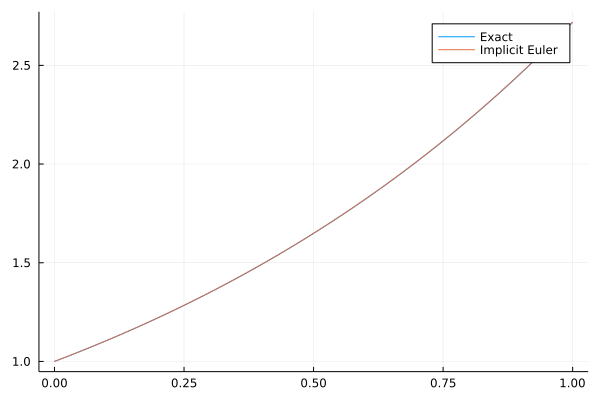

In [14]:
h = 1e-3
domain = 0:h:1

y = exp.(domain)
yhat = implicit_euler(identity, 1, 0, 1, h)

plot(domain, [y, yhat], labels=["Exact" "Implicit Euler"])

Then the last value in our solution vector is our approximation of $e^1 = e$.

In [15]:
yhat[end], exp(1)

(2.7196422164732823, 2.718281828459045)

This is a decent approximation. Making $h$ smaller will increase the accuracy. In addition, solving from a different starting point might increase the accuracy. However, starting at $x = 0$ is natural since $b^0 = 1\ \forall\ b$ is an initial condition that does not require any knowledge of the number $e$.

# Linear Algebra Algorithms

Let's define vector and matrix types, and various common linear algebra operations. Below, we define:
- matrix/vector/scalar arithmetic
- norms
- dot products

In [16]:
module Linalg
import Base: +, -, *, ==

struct Vector{T<:Number}
    elements::Array{T, 1}
end

checksize(x, y) = size(x.elements) == size(y.elements)
    
function +(x::Vector, y::Vector)
    @assert checksize(x, y)
    Vector([a + b for (a, b) in zip(x.elements, y.elements)])
end

function -(x::Vector, y::Vector)
    @assert checksize(x, y)
    Vector([a - b for (a, b) in zip(x.elements, y.elements)])
end

#Dot product
function *(x::Vector, y::Vector)
    @assert checksize(x, y)
    sum(a * b for (a, b) in zip(x.elements, y.elements))
end

function *(x::Vector, c::Number)
    Vector([xi * c for xi in x.elements])
end

function *(c::Number, x::Vector)
    x * c
end

struct Matrix{T<:Number}
    elements::Array{T, 2}
end

function +(A::Matrix, B::Matrix)
    @assert checksize(A, B)
    Matrix([a + b for (a, b) in zip(A.elements, B.elements)])
end

function -(A::Matrix, B::Matrix)
    @assert checksize(A, B)
    Matrix([a - b for (a, b) in zip(A.elements, B.elements)])
end

checkshape(A, B) = size(A.elements)[2] == size(B.elements)[1]

function prod_dims(A::Matrix, B::Matrix)
    size(A.elements)[1],
    size(A.elements)[2],
    size(B.elements)[2]
end

function *(A::Matrix, B::Matrix)
    @assert checkshape(A, B)
    
    m, n, p = prod_dims(A, B)
    elements = zeros(typeof(A.elements[1]), m, p)
    
    for i in 1:m
        for j in 1:p
            elements[i, j] = sum(A.elements[i, k] * B.elements[k, j] for k in 1:n)
        end
    end
    
    Matrix(elements)
end

function *(A::Matrix, B::Vector)
    @assert checkshape(A, B)
    
    m, n = size(A.elements)
    elements = zeros(typeof(A.elements[1]), m)
    
    for i in 1:m
        elements[i] = sum(A.elements[i, k] * B.elements[k] for k in 1:n)
    end
    
    Vector(elements)
end

function *(A::Matrix, c::Number)
    Matrix([Aij * c for Aij in A.elements])
end

function *(c::Number, A::Matrix)
    A * c
end

end #module

Main.Linalg

The following examples demonstrate arithmetic between these types:

In [17]:
x = Linalg.Vector{Float64}([1, 3])
y = Linalg.Vector{Float64}([2, 4])

Main.Linalg.Vector{Float64}([2.0, 4.0])

In [18]:
x + y

Main.Linalg.Vector{Float64}([3.0, 7.0])

In [19]:
y - x

Main.Linalg.Vector{Float64}([1.0, 1.0])

In [20]:
x * y

14.0

In [21]:
3*x

Main.Linalg.Vector{Float64}([3.0, 9.0])

In [22]:
y*2

Main.Linalg.Vector{Float64}([4.0, 8.0])

In [23]:
A = Linalg.Matrix{Float64}([1 2; 3 4])
B = Linalg.Matrix{Float64}([4 5; 7 8])

Main.Linalg.Matrix{Float64}([4.0 5.0; 7.0 8.0])

In [24]:
A + B

Main.Linalg.Matrix{Float64}([5.0 7.0; 10.0 12.0])

In [25]:
A - B

Main.Linalg.Matrix{Float64}([-3.0 -3.0; -4.0 -4.0])

In [26]:
A*B

Main.Linalg.Matrix{Float64}([18.0 21.0; 40.0 47.0])

In [27]:
3*A

Main.Linalg.Matrix{Float64}([3.0 6.0; 9.0 12.0])

In [28]:
B * 2

Main.Linalg.Matrix{Float64}([8.0 10.0; 14.0 16.0])

In [29]:
A*x

Main.Linalg.Vector{Float64}([7.0, 15.0])